# Пропущенные значения
Случаются пропущенные значения. Будьте готовы к этой распространенной проблеме в реальных наборах данных.

В этом руководстве вы познакомитесь с тремя подходами к работе с пропущенными значениями. Затем вы сравните эффективность этих подходов на реальном наборе данных.

# Вступление
Существует много способов, которыми данные могут содержать пропущенные значения. Например,

В доме с 2 спальнями не будет указано значение размера третьей спальни.
Респондент может не сообщать о своем доходе.
Большинство библиотек машинного обучения (включая scikit-learn) выдают ошибку, если вы пытаетесь построить модель, используя данные с пропущенными значениями. Поэтому вам нужно выбрать одну из стратегий, представленных ниже.

# Три подхода
1) Простой вариант: удалить столбцы с пропущенными значениями

Самый простой вариант - удалить столбцы с пропущенными значениями.
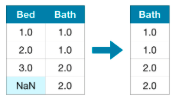
Если только большинство значений в удаленных столбцах не отсутствуют, модель теряет доступ к большому количеству (потенциально полезной!) информации при таком подходе. В качестве крайнего примера рассмотрим набор данных из 10 000 строк, в котором в одном важном столбце отсутствует единственная запись. Такой подход приведет к полному удалению столбца!

2) Лучший вариант: Условное вычисление

При условном вычислении недостающие значения заполняются некоторым числом. Например, мы можем заполнить среднее значение по каждому столбцу.
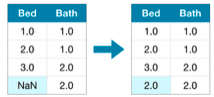
В большинстве случаев вычисленное значение не будет в точности соответствовать действительности, но обычно это приводит к созданию более точных моделей, чем при полном удалении столбца.

3) Расширение метода условного исчисления

Условное исчисление - это стандартный подход, и обычно он хорошо работает. Однако расчетные значения могут быть систематически выше или ниже их фактических значений (которые не были собраны в наборе данных). Или строки с пропущенными значениями могут быть уникальными каким-либо другим образом. В этом случае ваша модель будет лучше прогнозировать, учитывая, какие значения изначально отсутствовали.
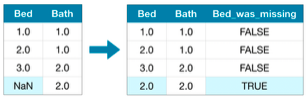
При таком подходе мы, как и прежде, вычисляем пропущенные значения. И, кроме того, для каждого столбца с отсутствующими записями в исходном наборе данных мы добавляем новый столбец, который показывает местоположение вычисленных записей.

В некоторых случаях это значительно улучшает результаты. В других случаях это вообще не помогает.

# Пример
В этом примере мы будем работать с набором данных по жилью в Мельбурне. Наша модель будет использовать такую информацию, как количество комнат и площадь земельного участка, для прогнозирования цены на жилье.

Мы не будем заострять внимание на этапе загрузки данных. Вместо этого вы можете представить, что у вас уже есть данные для обучения и проверки в X_train, X_valid, y_train и y_valid.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузить данные
data = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')

# Выберите цель
y = data.Price

# Чтобы упростить задачу, мы будем использовать только числовые предикторы
melb_predictors = data.drop(['Price'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])

# Разделите данные на обучающие и проверяющие подмножества.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

Определите функцию для измерения качества каждого подхода

Мы определяем функцию score_dataset() для сравнения различных подходов к работе с пропущенными значениями. Эта функция отображает среднюю абсолютную ошибку (MAE) из модели случайного леса.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Функция для сравнения различных подходов
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

Оценка по методу 1 (Удаление столбцов с пропущенными значениями)

Поскольку мы работаем как с обучающими, так и с проверочными наборами, мы стараемся удалять одни и те же столбцы в обоих фреймворках данных.

In [ ]:
# Получить имена столбцов с пропущенными значениями
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Удаление столбцов из данных об обучении и валидации
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

Оценка по методу 2 (условное вычисление)¶

Далее мы используем простые входные данные для замены пропущенных значений средним значением в каждом столбце.

Несмотря на то, что это просто, заполнение среднего значения в целом дает неплохие результаты (но это зависит от набора данных). В то время как статистики экспериментировали с более сложными способами определения условных значений (такими как, например, регрессионное вычисление), сложные стратегии, как правило, не дают дополнительной выгоды, если вы подключаете результаты к сложным моделям машинного обучения.

In [ ]:
from sklearn.impute import SimpleImputer

# Вменение
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Вменение удаленных имен столбцов; верните их обратно
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

Мы видим, что подход 2 имеет более низкий MAE, чем подход 1, поэтому подход 2 показал лучшие результаты в этом наборе данных.

Оценка по подходу 3 (дополнение к условному вычислению)

Далее мы вычисляем пропущенные значения, одновременно отслеживая, какие значения были вычислены.

In [ ]:
# Сделайте копию, чтобы избежать изменения исходных данных (при расчете)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Создайте новые столбцы, указывающие, что будет начисляться
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Вменение
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Вменение удаленных имен столбцов; верните их обратно
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

Как мы видим, подход 3 показал несколько худшие результаты, чем подход 2.

Итак, почему вменение показало лучшие результаты, чем удаление столбцов?

Данные для обучения содержат 10864 строки и 12 столбцов, где три столбца содержат недостающие данные. В каждом столбце отсутствует менее половины записей. Таким образом, удаление столбцов приводит к удалению большого количества полезной информации, и поэтому имеет смысл, что вменение будет работать лучше.

In [ ]:
# Форма обучающих данных (num_rows, num_columns)
print(X_train.shape)

# Количество пропущенных значений в каждом столбце обучающих данных
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

# Вывод¶
Как обычно, вычисление пропущенных значений (в подходах 2 и 3) дало лучшие результаты по сравнению с тем, когда мы просто удаляли столбцы с пропущенными значениями (в подходе 1).

# ваш ход
Сравните эти подходы к устранению пропущенных значений самостоятельно в этом упражнении!